# Import Library

In [ ]:
!pip install vectorbt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1
  Attempting uninstall: numba
    Found existing installation: numba 0.58.1
    Uninstalling numba-0.58.1:
      Successfully uninstalled numba-0.58.1


# Read Data

In [ ]:
import vectorbt

In [ ]:
import pandas as pd
data1= pd.read_csv('/content/HPG_day_ohlc.csv')

In [ ]:
# prompt: drop me columns Resolution Updated  Symbol Timestamp and set Time as index

data1.drop(columns = ['Resolution', 'Symbol', 'Timestamp','Last Updated'], axis=1, inplace=True)

data1['Time'] = pd.to_datetime(data1['Time'])
data1 = data1.set_index('Time')
# prompt: Sort the data1 by time
data1.sort_index(inplace=True)

In [ ]:
data1

,Open,High,Low,Close,Volume
Time,,,,,
2012-03-26 00:00:00,1.32,1.32,1.30,1.30,412710.0
2012-03-27 00:00:00,1.29,1.31,1.29,1.29,964010.0
2012-03-28 00:00:00,1.28,1.29,1.28,1.29,282250.0
2012-03-29 00:00:00,1.28,1.30,1.28,1.29,438730.0
2012-03-30 00:00:00,1.30,1.32,1.29,1.30,685020.0
...,...,...,...,...,...
2023-10-13 00:00:00,25.60,25.75,25.05,25.75,19572000.0
2023-10-16 02:00:00,25.75,25.80,25.00,25.00,16205000.0
2023-10-17 02:00:00,25.20,25.45,24.80,24.80,14705500.0


<ipython-input-6-428d795eee28>:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 4.2486, test RMSE 17.1176
Epoch 100: train RMSE 0.2360, test RMSE 0.9088
Epoch 200: train RMSE 0.2016, test RMSE 0.9922
Epoch 300: train RMSE 0.1765, test RMSE 0.9624
Epoch 400: train RMSE 0.1709, test RMSE 0.9262
Epoch 500: train RMSE 0.1519, test RMSE 0.8886
Epoch 600: train RMSE 0.1489, test RMSE 0.8845
Epoch 700: train RMSE 0.1423, test RMSE 0.9048


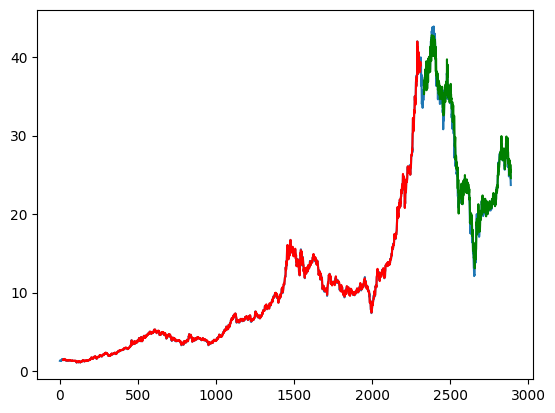

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

timeseries = data1[["Close"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
lookback = 20
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class ForecastPriceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = ForecastPriceModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 800
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

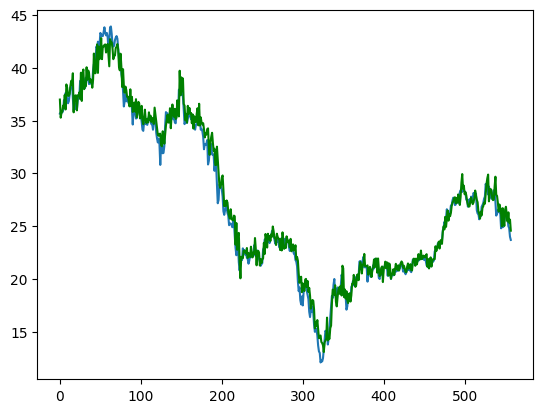

In [ ]:
timeseries = data1[["Close"]].values.astype('float32')

with torch.no_grad():
    # shift train predictions for plotting

    # shift test predictions for plotting
    timeseries = timeseries[train_size+lookback:len(timeseries)]

    test_plot = np.ones_like(timeseries) * np.nan
    test_plot = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(test_plot, c='g')
plt.show()

# Signal for Trading or Not

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame

def get_daily_volatility(Close, lookback=50):
    """
    Advances in Financial Machine Learning, Snippet 3.1, page 44.

    Daily Volatility Estimates

    Computes the daily volatility at intraday estimation points.

    In practice we want to set profit taking and stop-loss limits that are a function of the risks involved
    in a bet. Otherwise, sometimes we will be aiming too high (tao ≫ sigma_t_i,0), and sometimes too low
    (tao ≪ sigma_t_i,0 ), considering the prevailing volatility. Snippet 3.1 computes the daily volatility
    at intraday estimation points, applying a span of lookback days to an exponentially weighted moving
    standard deviation.

    See the pandas documentation for details on the pandas.Series.ewm function.
    Note: This function is used to compute dynamic thresholds for profit taking and stop loss limits.

    :param Close: (pd.Series) Closing prices
    :param lookback: (int) Lookback period to compute volatility
    :return: (pd.Series) Daily volatility value
    """
    # daily vol re-indexed to Close
    df0 = Close.index.searchsorted(Close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(Close.index[df0 - 1], index=Close.index[Close.shape[0] - df0.shape[0]:]))

    df0 = Close.loc[df0.index] / Close.loc[df0.array].array - 1  # daily returns

    df0 = df0.ewm(span=lookback).std()
    return df0

In [ ]:
get_daily_volatility(data1['Close'])

Time
2012-03-28 00:00:00         NaN
2012-03-29 00:00:00    0.005439
2012-03-30 00:00:00    0.007722
2012-04-03 00:00:00    0.009934
2012-04-04 00:00:00    0.008737
                         ...   
2023-10-13 00:00:00    0.025567
2023-10-16 02:00:00    0.025688
2023-10-17 02:00:00    0.026118
2023-10-18 02:00:00    0.026615
2023-10-19 02:00:00    0.027242
Name: Close, Length: 2888, dtype: float64

In [ ]:
def cusum_filter_Trading_signal(raw_time_series, threshold, time_stamps=True):
    pos_events = []
    negative_events = []
    s_pos = 0
    s_neg = 0
    raw_time_series = pd.DataFrame(raw_time_series)  # Convert to DataFrame
    raw_time_series.columns = ['price']
    raw_time_series['log_ret'] = raw_time_series.price.apply(np.log).diff()
    if isinstance(threshold, (float, int)):
        raw_time_series['threshold'] = threshold
    elif isinstance(threshold, pd.Series):
        raw_time_series.loc[threshold.index, 'threshold'] = threshold
    else:
        raise ValueError('threshold is neither float nor pd.Series!')

    raw_time_series = raw_time_series.iloc[1:]  # Drop first na values

    # Get event time stamps for the entire series
    for tup in raw_time_series.itertuples():
        thresh = tup.threshold
        pos = float(s_pos + tup.log_ret)
        neg = float(s_neg + tup.log_ret)
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -thresh:
            s_neg = 0
            negative_events.append(tup.Index)

        elif s_pos > thresh:
            s_pos = 0
            pos_events.append(tup.Index)

    return pos_events,negative_events

# Backtesting and Performance Evaluation Result

In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
timeseries = data1[["Close"]].values.astype('float32')


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
lookback = 20
# X_train, y_train = create_dataset(train, lookback=lookback)
# X_test, y_test = create_dataset(test, lookback=lookback)

In [ ]:
x,y = create_dataset(timeseries,20)

In [ ]:
import numpy as np

# Assuming model(x)[:, -1, :] returns a NumPy array
predicted_values = model(x)[:, -1, :].detach().numpy()

# Length you want the final array to be
desired_length = 2890

# Calculate the number of NaN values to add at the beginning
nan_padding_length = desired_length - len(predicted_values)

# Create an array of NaN values
nan_padding = np.full((nan_padding_length, predicted_values.shape[1]), np.nan)

# Concatenate NaN padding with the original predicted values
extended_array = np.concatenate((nan_padding, predicted_values), axis=0)

In [ ]:
data1['predict'] = extended_array

In [ ]:
data1

,Open,High,Low,Close,Volume,predict
Time,,,,,,
2012-03-26 00:00:00,1.32,1.32,1.30,1.30,412710.0,NaN
2012-03-27 00:00:00,1.29,1.31,1.29,1.29,964010.0,NaN
2012-03-28 00:00:00,1.28,1.29,1.28,1.29,282250.0,NaN
2012-03-29 00:00:00,1.28,1.30,1.28,1.29,438730.0,NaN
2012-03-30 00:00:00,1.30,1.32,1.29,1.30,685020.0,NaN
...,...,...,...,...,...,...
2023-10-13 00:00:00,25.60,25.75,25.05,25.75,19572000.0,25.446053
2023-10-16 02:00:00,25.75,25.80,25.00,25.00,16205000.0,26.307291
2023-10-17 02:00:00,25.20,25.45,24.80,24.80,14705500.0,25.326365


In [ ]:
import vectorbt as vbt
import pandas as pd
# Trading or not Based on Cumalative Sum Trading Filter
vol = get_daily_volatility(Close=data1['Close'],lookback=20)
k ,l =cusum_filter_Trading_signal(data1['Close'], threshold=vol.mean()*0.1)


data1['Order'] = 0 # Initialize the new column with some default value
data1.loc[data1.index.isin(k), 'Order'] = 1
indices_where_predict_is_1 = data1[data1['Order'] == 1].index
df1 = pd.DataFrame(data1['Close'])
filtered_rows = df1.loc[indices_where_predict_is_1]
# XỬ lý lệnh bán khi nào expected price chạm ngưỡng thì bán

# Ảnh hưởng đến model prediction
vol = get_daily_volatility(Close=data1['Close'], lookback=20)
# Chưa rõ set như nào
filtered_rows['expected_price'] = data1['predict']

filtered_rows['pt'] = (filtered_rows['Close']-filtered_rows['expected_price']) *100
# # Model của Việt
df = filtered_rows.dropna()
# df = df[df['pt']>=1] # Generate signal when the profit percentage > 2%
# df = df[df['pt']< 3] # Generate signal when the profit percentage < 3%

In [ ]:
filtered_rows

,Close,expected_price,pt
Time,,,
2012-03-30 00:00:00,1.30,NaN,NaN
2012-04-03 00:00:00,1.32,NaN,NaN
2012-04-05 00:00:00,1.33,NaN,NaN
2012-04-10 00:00:00,1.33,NaN,NaN
2012-04-11 00:00:00,1.39,NaN,NaN
...,...,...,...
2023-09-28 02:00:00,26.60,26.391665,20.833549
2023-10-04 02:00:00,25.25,24.982183,26.781654
2023-10-09 02:00:00,25.50,25.025927,47.407341


In [ ]:
df = filtered_rows.dropna()
# df = df[df['pt']>=2] # Generate signal when the profit percentage > 2%
# df = df[df['pt']< 3] # Generate signal when the profit percentage < 3%


data1['Order'] = 0 # Initialize the new column with some default value
data1.loc[df.index, 'Order'] = 1
Right = 0
Wrong = 0
for i in df.index:
    end_time = i + pd.Timedelta(days=7)
    prices_within_7_days = data1.loc[i:end_time, 'Close']
    d1 = pd.DataFrame(prices_within_7_days)
    filtered_rows = d1[d1['Close'] > df['expected_price'][i]]
    first_row = filtered_rows.index
    d2 = pd.DataFrame(first_row)
    if len(d2) != 0 :
      Right += 1
      if int(data1.loc[d2.iloc[0], 'Order']) < 0 :
        data1.loc[d2.iloc[0], 'Order'] -= 1
      elif int(data1.loc[d2.iloc[0], 'Order']) >0 :
        data1.loc[d2.iloc[0], 'Order'] -= 1
      else:
        data1.loc[d2.iloc[0], 'Order'] = -1
    else:
      Wrong += 1
      if int(data1.loc[d1.iloc[-1].name, 'Order']) < 0 :
        data1.loc[d1.iloc[-1].name, 'Order'] -= 1
      elif int(data1.loc[d1.iloc[-1].name, 'Order']) >0 :
        data1.loc[d1.iloc[-1].name, 'Order'] -= 1
      else:
        data1.loc[d1.iloc[-1].name, 'Order'] = -1
cum_ac = (Right)/(Right+Wrong)*100

pf = vbt.Portfolio.from_orders( data1['Close'], size = data1['Order'] ,init_cash=10000, freq='1h')
cusum_pf = pf.total_profit()
cusum_sharpe = dict(pf.stats())['Sharpe Ratio']
df = pf.orders.records_readable
pf.plot().show()

total_amount_spent = df.loc[df['Side'] == 'Buy', 'Size'] * df.loc[df['Side'] == 'Buy', 'Price']
total_amount_spent = total_amount_spent.sum()
return_cum = (pf.total_profit()/total_amount_spent)*100
print('Số tiền dùng để mua stock',total_amount_spent)
print('Lợi nhuận sau khi trading',pf.total_profit())


Số tiền dùng để mua stock 3973.7700000000004
Lợi nhuận sau khi trading 12.799999999999965


In [ ]:
pf.stats()